<a href="https://colab.research.google.com/github/RonBartov/Erasure_Probabilities_and_Error_Correction/blob/main/erasure_probabilities_and_error_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Erasure Probabilities and Error Correction Simulations in Channel Decoding**

## **Background**
The following assignment focuses on understanding and simulating the behavior of error correction systems in binary erasure channels (BEC). The tasks involve computing erasure probabilities, implementing encoding and decoding functions, and analyzing system performance under various configurations.

**Key objectives include:**

${\circ}$ Developing and simulating functions for error probabilities and bit-channel transforms.

${\circ}$ Understanding how erasure probabilities evolve in a BEC under specific conditions.

${\circ}$ Analyzing decoding success rates, frame error rates (FER), and multi-channel communication.

# HERE, ADDITIONAL INFORMATION WILL BE ADDED
- NOTES
- DIVIDING THE ASSIGNMENT INTO DIFFERENT PARTS

# IN SEPARATE TEXT BOX, THE THEORY AND FORMULAS FOR CALCULATING PROBABILITIES WILL BE ADDED

# Import Necessary Libraries

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Part 1: Computing Erasure Probabilities

This part will include the following:

${\circ}$ Implementing functions for computing and plotting erasure probabilities, based on the theoretical background.

${\circ}$ Analysis of results and observed phenomena.

In [ ]:
def verify_power_of_two(n: int) -> None:
    """
    Verifies whether a given integer is a power of two.

    Args:
        n (int): The integer to check.

    Raises:
        ValueError: If `n` is not a positive power of two.
    """
    if n <= 0 or (n & (n - 1)) != 0:
        raise ValueError(f"Input must be a positive power of two, but got {n}.")

In [ ]:
def permutation_block(layer: int, input_array: np.ndarray) -> np.ndarray:
    """
    Permutes the elements of an input numpy array based on the specified layer value.

    The function rearranges the elements of the input array according to the following rules:
    - For indices j = 0, ..., 2^(l+1)-1:
      - If j < 2^l: the element at index j is moved to index 2j.
      - Otherwise (j >= 2^l): the element at index j is moved to index 2(j - 2^l) + 1.

    Args:
        layer (int): The layer value 'l' that determines the permutation logic.
        input_array (np.ndarray): The numpy array of floats to be permuted.

    Returns:
        np.ndarray: A new numpy array with elements permuted according to the given rules.

    Raises:
        ValueError: If the length of the input array is not equal to 2^(l+1).
    """
    n = len(input_array)
    expected_length = 2 ** (layer + 1)

    if n != expected_length:
        raise ValueError(f"Input array length must be {expected_length}, but got {n}.")

    permuted_array = np.zeros_like(input_array)  # Initialize a new array of the same size with zeros
    threshold = 2 ** layer

    for j in range(n):
        if j < threshold:
            new_index = 2 * j
        else:
            new_index = 2 * (j - threshold) + 1

        permuted_array[new_index] = input_array[j]

    return permuted_array

In [ ]:
def array_permutation_by_block(layer: int, input_array: np.ndarray) -> np.ndarray:
    """
    Permutes the elements of an input numpy array by blocks using the permutation_block function.

    The input array is divided into blocks of size 2^(l+1), and the permutation_block function
    is applied to each block. The permuted blocks are then concatenated to form the final output array.

    Args:
        layer (int): The layer value 'l' that determines the block size and permutation logic.
        input_array (np.ndarray): The numpy array of floats to be permuted by blocks.

    Returns:
        np.ndarray: A new numpy array with elements permuted by blocks according to the given rules.

    Raises:
        ValueError: If the size of the input array is not a multiple of the block size.
    """
    n = len(input_array)
    block_size = 2 ** (layer + 1)

    if n % block_size != 0:
        raise ValueError(f"Input array size must be a multiple of the block size {block_size}, but got {n}.")

    num_blocks = n // block_size
    permuted_array = []

    for i in range(num_blocks):
        block_start = i * block_size
        block_end = block_start + block_size
        block = input_array[block_start:block_end]
        permuted_block = permutation_block(layer, block)
        permuted_array.append(permuted_block)

    return np.concatenate(permuted_array)

In [ ]:
def effective_bit_channels_in_bcd(error_probabilities: np.ndarray) -> np.ndarray:
    """
    Calculates the effective bit channels for a bit channel decoder based on input error probabilities.

    The function computes the effective bit channel probabilities for the decoder output using the input
    error probabilities. The calculation is based on even and odd indexed elements as follows:
    - For even indices j = 0, 2, ..., n-2:
      x_out[j] = 1 - [1 - x_in[j]] * [1 - x_in[j+1]]
    - For odd indices k = 1, 3, ..., n-1:
      x_out[k] = x_in[k-1] * x_in[k]

    Args:
        error_probabilities (np.ndarray): A numpy array of floats representing the input error probabilities.

    Returns:
        np.ndarray: A numpy array of floats representing the effective bit channel probabilities for the decoder output.

    Raises:
        ValueError: If the length of the input array is not a power of 2.
    """
    n = len(error_probabilities)

    if not (n and (n & (n - 1)) == 0):
        raise ValueError("Input array length must be a power of 2, but got {n}.")

    output_probabilities = np.zeros_like(error_probabilities)

    for j in range(0, n, 2):
        output_probabilities[j] = 1 - (1 - error_probabilities[j]) * (1 - error_probabilities[j + 1])

    for k in range(1, n, 2):
        output_probabilities[k] = error_probabilities[k - 1] * error_probabilities[k]

    return output_probabilities

In [ ]:
def erasure_probability_recursive_u_transform(n: int, epsilon: int) -> np.ndarray:
    """
    Computes the erasure probabilities of bit channels recursively using the U-transform.

    Args:
        n (int): The block size, which must be a power of 2. Represents the total number of bit channels.
        epsilon (int): The initial erasure probability of the input channels.

    Returns:
        np.ndarray: A NumPy array of size `n` containing the computed erasure probabilities
                    for each bit channel.

    Raises:
        ValueError: If `n` is not a power of 2 or is less than 2.

    Note:
        - The function uses recursive splitting to compute the probabilities, halving the
          size of the problem in each recursive step.
        - The `effective_bit_channels_in_bcd` function is used to calculate the erasure
          probabilities after combining the split channels.
        - The `permutation_block` function applies a specific permutation to the input
          probabilities, based on the current layer of recursion.

    """
    verify_power_of_two(n)

    if n == 2:
        input_probabilities = np.array([epsilon, epsilon])
        output_probabilities = effective_bit_channels_in_bcd(input_probabilities)
        # print(f"n: {n}, probs: {output_probabilities}")
        return output_probabilities
    else:
        layer = int(math.log2(n)) - 1
        input_probabilities_half_size = erasure_probability_recursive_u_transform(n//2, epsilon)
        input_probabilities = np.concatenate((input_probabilities_half_size, input_probabilities_half_size))
        input_probabilities_after_permutation = permutation_block(layer, input_probabilities)
        output_probabilities = effective_bit_channels_in_bcd(input_probabilities_after_permutation)
        # print(f"n: {n}, probs: {output_probabilities}")
        return output_probabilities

# SIMULATION FOR PART 1: TO EXPLAIN HERE

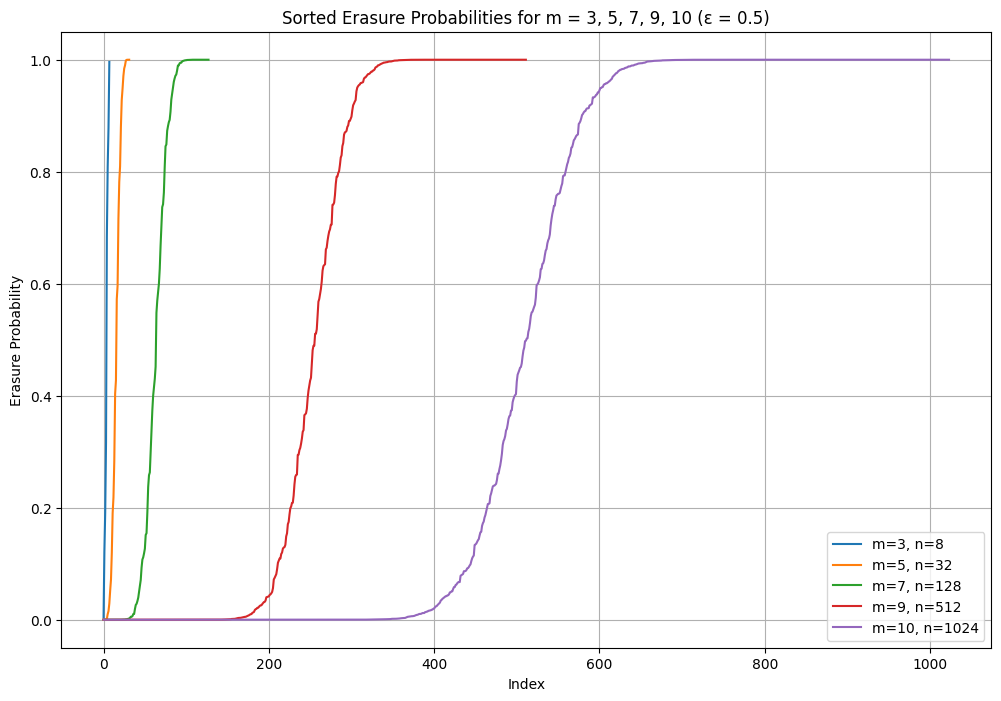

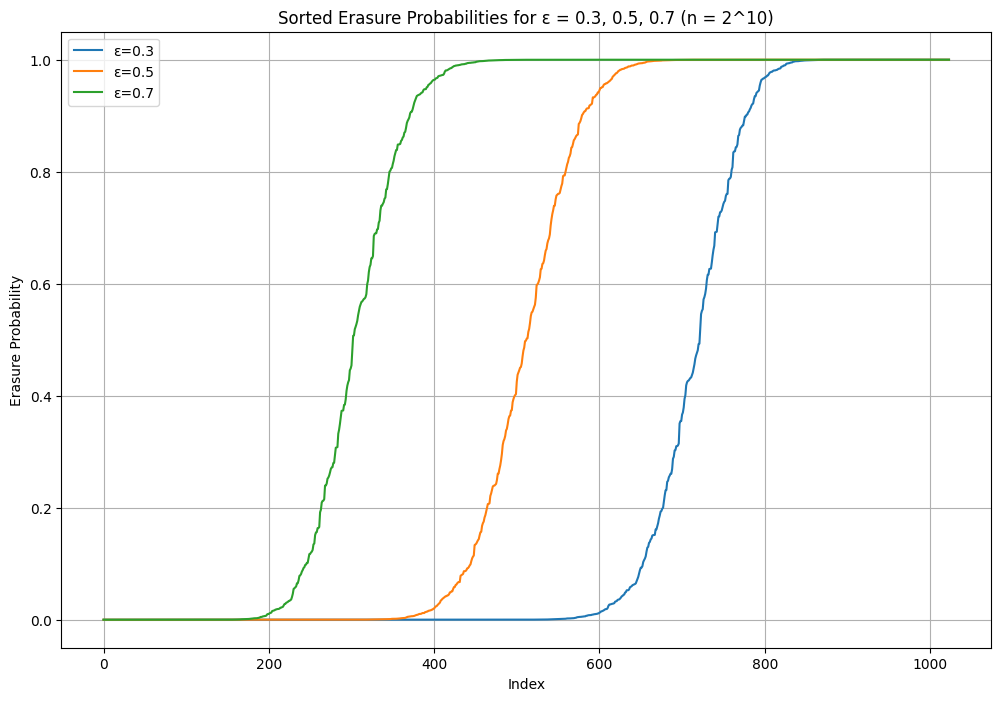

In [ ]:
# Part 1: Plot for m = 3, 5, 7, 9, 10 and ε = 0.5
m_values = [3, 5, 7, 9, 10]
epsilon = 0.5

plt.figure(figsize=(12, 8))
for m in m_values:
    n = 2 ** m
    probabilities = erasure_probability_recursive_u_transform(n, epsilon)
    sorted_probabilities = np.sort(probabilities)
    plt.plot(sorted_probabilities, label=f'm={m}, n={n}')

plt.title('Sorted Erasure Probabilities for m = 3, 5, 7, 9, 10 (ε = 0.5)')
plt.xlabel('Index')
plt.ylabel('Erasure Probability')
plt.legend()
plt.grid(True)
plt.show()

# Part 2: Plot for ε = 0.3, 0.5, 0.7 and n = 2^10
epsilon_values = [0.3, 0.5, 0.7]
n = 2 ** 10

plt.figure(figsize=(12, 8))
for epsilon in epsilon_values:
    probabilities = erasure_probability_recursive_u_transform(n, epsilon)
    sorted_probabilities = np.sort(probabilities)
    plt.plot(sorted_probabilities, label=f'ε={epsilon}')

plt.title('Sorted Erasure Probabilities for ε = 0.3, 0.5, 0.7 (n = 2^10)')
plt.xlabel('Index')
plt.ylabel('Erasure Probability')
plt.legend()
plt.grid(True)
plt.show()

# PART 2: Encoder, Channel, Decoder

In [ ]:
def xor(a: int, b: int) -> int:
    """
    Performs XOR between two bits, handling erased (-1) bits.

    Args:
        a (int): First bit (0, 1, or -1 for erased).
        b (int): Second bit (0, 1, or -1 for erased).

    Returns:
        int: Result of XOR operation (0, 1, or -1 for erased).
             Returns -1 if either input is -1.
    """
    if a == -1 or b == -1:
        return -1
    return a ^ b

In [ ]:
def transform_array_length_4(arr_in: np.ndarray) -> np.ndarray:
    """
    Transforms a 4-bit input array `arr_in` to a 4-bit output array
    based on specified XOR operations and rules for handling erased bits (-1).

    Args:
        arr_in (np.ndarray): A numpy array of 4 input bits (0, 1, or -1 for erased bits).

    Returns:
        np.ndarray: A numpy array of 4 output bits transformed according to the rules.
    """

    n = len(arr_in)

    if n != 4:
        raise ValueError(f"Input array size must be 4, but got {n}.")

    # Compute arr_out_0
    arr_out_0 = xor(xor(xor(arr_in[0], arr_in[1]), arr_in[2]), arr_in[3])

    # Compute arr_out_1
    arr_out_1 = xor(arr_in[2], arr_in[3]) if arr_in[2] != -1 and arr_in[3] != -1 else xor(xor(arr_in[0], arr_out_0), arr_in[1])

    # Compute arr_out_2
    if arr_in[1] != -1 and arr_in[3] != -1:
        arr_out_2 = xor(arr_in[1], arr_in[3])
    elif arr_in[0] != -1 and arr_out_0 != -1 and arr_in[1] != -1 and arr_in[3] != -1:
        arr_out_2 = xor(xor(arr_in[0], arr_in[1]), xor(arr_out_0, arr_in[3]))
    elif arr_in[0] != -1 and arr_out_0 != -1 and arr_in[2] != -1:
        arr_out_2 = xor(xor(arr_in[0], arr_out_0), arr_in[2])
    elif arr_in[1] != -1 and arr_in[2] != -1 and arr_out_0 != -1:
        arr_out_2 = xor(xor(arr_in[1], arr_in[2]), arr_out_0)
    else:
        arr_out_2 = -1

    # Compute arr_out_3
    if arr_in[3] != -1:
        arr_out_3 = arr_in[3]
    elif arr_out_0 != -1 and arr_in[2] != -1:
        arr_out_3 = xor(arr_out_0, arr_in[2])
    elif arr_out_1 != -1 and arr_in[1] != -1:
        arr_out_3 = xor(arr_out_1, arr_in[1])
    elif arr_in[0] != -1 and arr_out_0 != -1 and arr_in[3] != -1 and arr_out_1 != -1:
        arr_out_3 = xor(xor(xor(arr_in[0], arr_out_0), arr_out_1), arr_in[3])
    else:
        arr_out_3 = -1

    return np.array([arr_out_0, arr_out_1, arr_out_2, arr_out_3])

In [ ]:
def encode(i: list, info_locs: list, n: int = 4) -> np.ndarray:
    """
    Encodes an information bits vector `i` into a length-4 codeword `x` based on
    specified bit-channel indexes and transformation rules.

    Args:
        i (list): A list of information bits to be encoded.
        info_locs (list): A list of bit-channel indexes where the information bits are placed.
        n (int, optional): Length of the codeword. Default is 4.

    Returns:
        np.ndarray: A numpy array representing the encoded length-4 codeword `x`.

    Raises:
        ValueError: If `n` is not 4, or if the length of `info_locs` does not match the length of `i`.
    """
    if n != 4:
        raise ValueError(f"Only n=4 is supported, but got {n}.")

    if len(info_locs) != len(i):
        raise ValueError("The length of `info_locs` must match the length of `i`.")

    # Initialize the `u` vector
    u = np.zeros(n, dtype=int)

    # Place the information bits in `u` at the specified positions
    for idx, loc in enumerate(info_locs):
        u[loc] = i[idx]

    # Transform `u` to `x`
    x = transform_array_length_4(u)

    return x

In [ ]:
def channel(x: np.ndarray, eps: float) -> np.ndarray:
    """
    Simulates a communication channel that erases each bit in the input vector `x` with
    a given probability `eps` and outputs the resulting vector `y`.

    Args:
        x (np.ndarray): A numpy array of input bits (0 or 1).
        eps (float): The probability of erasing a bit (must be between 0 and 1).

    Returns:
        np.ndarray: A numpy array where each bit is either unchanged, erased (-1), or retained (0 or 1).

    Raises:
        ValueError: If `eps` is not in the range [0, 1].
    """
    if not (0 <= eps <= 1):
        raise ValueError(f"Erasure probability `eps` must be between 0 and 1, but got {eps}.")

    # Generate random values to decide erasure
    random_values = np.random.rand(len(x))

    # Create the output array
    y = np.where(random_values < eps, -1, x)  # Erase the bit with probability `eps`

    return y

In [ ]:
def decoder(y: np.ndarray, info_locs: list) -> bool:
    """
    Decodes a noisy vector `y` using the specified information bit locations (`info_locs`).
    The function applies the transformation and checks if the final `u` vector has any erased bits.

    Args:
        y (np.ndarray): A numpy array representing the noisy received vector `y` with potential erasures (-1).
        info_locs (list): A list of bit-channel indexes where the information bits were placed.

    Returns:
        bool: True if decoding was successful (none of the `u`'s are erased), False otherwise.
    """

    # Step 1: Apply the transformation to get the initial `u` vector
    u = transform_array_length_4(y)

    # Step 2: Set `u_j = 0` for each `j` not in `info_locs`
    for j in range(4):
        if j not in info_locs:
            u[j] = 0

    # Step 3: Check if any `u` values are erased (-1)
    if -1 in u:
        return False  # Decoding failed due to erased values

    return True  # Decoding was successful (no erased values)